# cs109a Final Project Milestone 3: EDA

In [1]:
# Import libraries
import os
import time
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import r2_score, confusion_matrix, classification_report, roc_curve
from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score
import warnings
warnings.filterwarnings("ignore")
plt.style.use('seaborn-notebook')
sns.set_style('darkgrid')
# pandas tricks for better display
pd.options.display.max_columns = 50  
pd.options.display.max_rows = 500     
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

## Helper Functions

In [2]:
# helper functions

def visualize_class_imbalance(series, partition='Training', figsize=(5, 2)):
    # Visualize class imbalance
    plt.figure(figsize=figsize)
    series.value_counts().plot(kind='barh')
    plt.title(f'Class Distribution for {partition} Data')
    plt.ylabel('Class Label')
    plt.xlabel('Number of Samples')
    plt.show()

def create_A1Cencounters(df):
    # 1. create copy of 'A1Cresult' in new column
    df['A1Cencounters'] = df['A1Cresult']
    # 2. convert 'Norm' and '>7' to 'norm'
    df['A1Cencounters'] = df['A1Cencounters'].replace(['normal', '>7'], 'normal')
    # 3. convert '>8' with 'change' == 'No'
    df.loc[(df['A1Cencounters'] == '>8') & (df['change'] == 'No'), 'A1Cencounters'] = '>8_no_change'
    # 4. convert '>8' with 'change' == 'Ch'
    df.loc[(df['A1Cencounters'] == '>8') & (df['change'] == 'Ch'), 'A1Cencounters'] = '>8_yes_change'
    return df

def visualize_missingness(df, partition='Training', figsize=(6, 7)):
    # calculate missing data percentages
    missing_data_percentage = (df.isnull().sum() / len(df)) * 100
    # sort by percentage
    missing_data_percentage = missing_data_percentage.sort_values(ascending=True)
    # visualize using horizontal barplot
    plt.figure(figsize=figsize)
    missing_data_percentage.plot(kind='barh')
    plt.title(f'Percentage of Missing Data by Column for {partition} Data')
    plt.xlabel('Percentage Missing (%)')
    plt.ylabel('Columns')
    plt.show()

def missing_values_table(df, partition='training'):
    # count the missing values for each column
    missing_values = df.isnull().sum()
    # calculate the percentage of missing values
    missing_percentage = (100 * df.isnull().sum() / len(df))
    # create a table with the results
    missing_values_table = pd.concat([missing_values, missing_percentage], axis=1)
    # rename the columns
    missing_values_table_columns = missing_values_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    # sort the table by percentage of missing in descending order
    missing_values_table_columns = missing_values_table_columns[
        missing_values_table_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
    # print a summary
    print(f"The {partition} data have " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(missing_values_table_columns.shape[0]) +
            " columns that have missing values.\n")
    # return the dataframe with missing info
    return missing_values_table_columns
    
def handle_missing_data(df):
    # keep track of the original columns
    original_columns = df.columns.tolist()
    # create dummy columns only for columns with missing data
    for col in original_columns:
        if df[col].isna().any(): 
            df[col + "_is_missing"] = df[col].isna().astype(int)
    # define imputers
    numeric_imputer = SimpleImputer(strategy='median')
    categorical_imputer = SimpleImputer(strategy='most_frequent')
    # impute median values for numeric columns and most frequent value for non-numeric columns
    for col in original_columns:
        if df[col].dtype in [np.float64, np.int64]: 
            df[col] = numeric_imputer.fit_transform(df[[col]]).flatten()
        else:  
            df[col] = categorical_imputer.fit_transform(df[[col]]).flatten() 
    return df

def scale_data(df, columns_to_scale):
    scaler = StandardScaler()
    df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])
    return df

## Load Data

In [3]:
# load data
df = pd.read_csv('../data/diabetic_data.csv', na_values='?')

# examine first 5 rows of dataframe
print(f'Shape of diabetic data: {df.shape}\n')
display(df.head())

Shape of diabetic data: (101766, 50)



,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,NaN,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,NaN,NaN,1,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,NaN,NaN,59,0,18,0,0,0,276,250.01,255,9,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,NaN,NaN,11,5,13,2,0,1,648,250,V27,6,NaN,NaN,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,NaN,NaN,44,1,16,0,0,0,8,250.43,403,7,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,NaN,51,0,8,0,0,0,197,157,250,5,NaN,NaN,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [55]:
missing_values_table(df)

The training data have 51 columns.
There are 7 columns that have missing values.



,Missing Values,% of Total Values
weight,98569,96.9
medical_specialty,49949,49.1
payer_code,40256,39.6
race,2273,2.2
diag_3,1423,1.4
diag_2,358,0.4
diag_1,21,0.0


## Recode Some Key Features

In [4]:
# recode target to binary
df['readmitted'] = df['readmitted'].map({'NO': 0, '>30': 0, '<30': 1})
df['readmitted'].value_counts() # sanity check

readmitted
0    90409
1    11357
Name: count, dtype: int64

In [5]:
# change A1c test result values (Hemoglobin A1c)
df['A1Cresult'] = df['A1Cresult'].fillna('none')
df['A1Cresult'] = df['A1Cresult'].replace('Norm', 'normal')
df['A1Cresult'].value_counts() # sanity check

A1Cresult
none      84748
>8         8216
normal     4990
>7         3812
Name: count, dtype: int64

In [6]:
# create new HbA1c encounters feature (see paper)
df = create_A1Cencounters(df)
df['A1Cencounters'].value_counts() # sanity check

A1Cencounters
none             84748
normal            8802
>8_yes_change     5349
>8_no_change      2867
Name: count, dtype: int64

In [7]:
# change some glucose serum test result values
df['max_glu_serum'] = df['max_glu_serum'].fillna('none')
df['max_glu_serum'] = df['max_glu_serum'].replace('Norm', 'normal')
df['max_glu_serum'].value_counts() # sanity check

max_glu_serum
none      96420
normal     2597
>200       1485
>300       1264
Name: count, dtype: int64

## Deal with Clustering by Patient

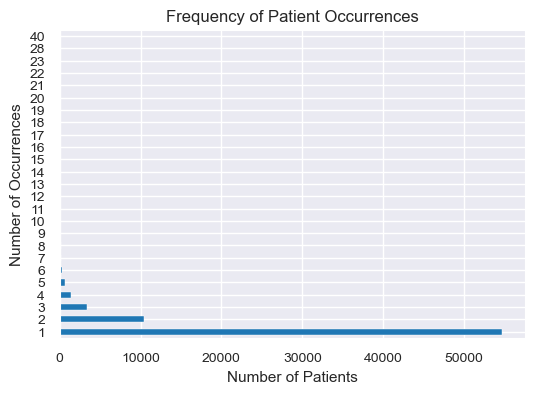

In [22]:
# calculate the frequency of each 'patient_id'
id_counts = df['patient_nbr'].value_counts()
# count how many 'patient_id's occur for each frequency
frequency_counts = id_counts.value_counts().sort_index()

plt.figure(figsize=(6,4))
frequency_counts.plot(kind='barh')
plt.ylabel('Number of Occurrences')
plt.xlabel('Number of Patients')
plt.title('Frequency of Patient Occurrences')
plt.show()

16773

In [35]:
# group by 'patient_id' and filter out those with only one occurrence
multiple_occurrences = df.groupby('patient_nbr').filter(lambda x: len(x) > 1)

print(f"Total number of patients with multple occurrences: {multiple_occurrences['patient_nbr'].nunique()}")

# check if 'readmitted' values vary within each group
def check_variation(df):
    return df['readmitted'].nunique() > 1

variation = multiple_occurrences.groupby('patient_nbr').apply(check_variation)

Total number of patients with multple occurences: 16773


In [68]:
# Print all patient_ids with variation in 'readmitted' values
#print(variation[variation])

# view the actual variations
patients_with_variation = variation[variation].index
#print(multiple_occurrences[multiple_occurrences['patient_nbr'].isin(patients_with_variation)])

Total number of patients with different outcomes across occurrences: 6481



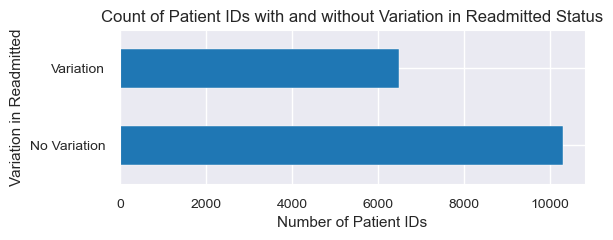

In [39]:
variation_int = variation.astype(int)
# get the counts of each category (0 and 1).
variation_counts = variation_int.value_counts().sort_index()

print(f"Total number of patients with different outcomes across occurrences: {variation_int.value_counts()[1]}\n")

plt.figure(figsize=(6,2))
variation_counts.plot(kind='barh')
plt.xlabel('Number of Patient IDs')
plt.ylabel('Variation in Readmitted')
plt.title('Count of Patient IDs with and without Variation in Readmitted Status')
plt.yticks(ticks=[0, 1], labels=['No Variation', 'Variation'])
plt.show()

In [52]:
# filter the original DataFrame to include only these patient IDs
df_with_variation = df[df['patient_nbr'].isin(patients_with_variation)]
df_with_variation[['patient_nbr', 'A1Cresult', 'readmitted']].sort_values('patient_nbr').head(10)

,patient_nbr,A1Cresult,readmitted
4780,135,none,0
4267,135,none,1
15848,1314,none,0
19765,1314,none,1
19914,1314,none,0
18390,11394,none,0
7665,11394,>8,0
13674,11394,none,1
7923,11511,none,0
5123,11511,none,1


In [71]:
df_with_variation['number_diagnoses'].value_counts()

number_diagnoses
9     12617
8      2379
7      2148
5      1902
6      1885
4       880
3       402
2       109
1        22
16       10
10        8
13        6
15        4
11        3
14        2
12        2
Name: count, dtype: int64

In [54]:
df_with_variation.sort_values('patient_nbr').head(20)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,...,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,A1Cencounters
4780,26264286,135,Caucasian,Female,[50-60),NaN,1,1,7,3,NaN,Surgery-Cardiovascular/Thoracic,31,1,14,0,0,1,998,41,250,5,none,none,Steady,...,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Ch,Yes,0,none
4267,24437208,135,Caucasian,Female,[50-60),NaN,2,1,1,8,NaN,Cardiology,77,6,33,0,0,0,401,997,560,8,none,none,Steady,...,No,No,No,No,No,Down,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,1,none
15848,60254142,1314,Caucasian,Female,[40-50),NaN,2,1,1,2,NaN,InternalMedicine,50,5,13,0,0,0,996,411,401,9,none,none,No,...,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,0,none
19765,70190028,1314,Caucasian,Female,[40-50),NaN,1,1,7,1,NaN,InternalMedicine,47,5,12,0,0,1,414,411,250.01,7,none,none,No,...,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,1,none
19914,70601076,1314,Caucasian,Female,[40-50),NaN,1,1,7,3,NaN,Cardiology,54,3,14,0,0,2,78,250,414,7,none,none,Steady,...,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,0,none
18390,66624354,11394,AfricanAmerican,Female,[80-90),NaN,1,6,7,4,NaN,InternalMedicine,47,1,7,0,0,2,599,280,403,9,none,none,No,...,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,0,none
7665,35935938,11394,AfricanAmerican,Female,[80-90),NaN,1,6,7,7,NaN,Pulmonology,62,2,14,0,0,0,38,599,250.02,9,none,>8,No,...,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,0,>8_yes_change
13674,54021606,11394,AfricanAmerican,Female,[80-90),NaN,1,1,7,5,NaN,Pulmonology,75,3,16,0,0,1,211,560,280,9,none,none,No,...,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,1,none
7923,36676056,11511,Caucasian,Male,[70-80),NaN,2,1,1,13,NaN,InternalMedicine,67,1,19,0,0,3,428,425,424,9,none,none,No,...,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,0,none
5123,27315318,11511,Caucasian,Male,[70-80),NaN,2,1,1,3,NaN,InternalMedicine,56,0,10,0,0,0,428,276,427,9,none,none,No,...,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,1,none


## Partition Data

In [60]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('readmitted', axis=1), 
    df['readmitted'],
    train_size=0.8, 
    random_state=109,
    shuffle=True,
    stratify=df['readmitted'],
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((81412, 50), (20354, 50), (81412,), (20354,))

## EDA

### Class Imbalance

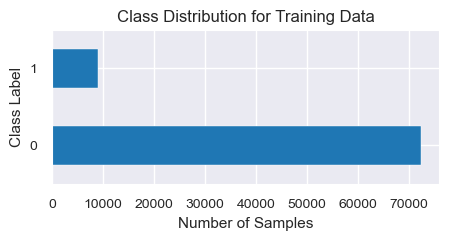

In [61]:
# class imbalance
visualize_class_imbalance(y_train)

**Question:** Can we use SMOTE (synthetic minority oversampling)? Seems like it's only available in `imblearn`, which isn't in the list of class packages. If not, should we just use classifiers that can adjust class weights, or roll our own procedure to oversample the minority class?

### Missing Data

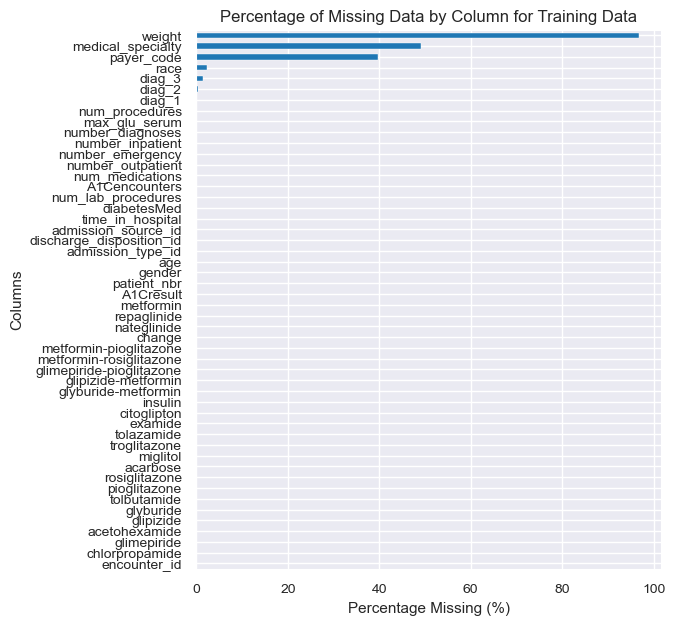

In [10]:
# visualize missingness
visualize_missingness(X_train)

In [11]:
# missing values table
missing_values_table(X_train)

The training data have 50 columns.
There are 7 columns that have missing values.



,Missing Values,% of Total Values
weight,78862,96.9
medical_specialty,39927,49.0
payer_code,32265,39.6
race,1846,2.3
diag_3,1129,1.4
diag_2,282,0.3
diag_1,18,0.0


In [12]:
X_train[['weight', 'medical_specialty', 'payer_code']].head(10)

,weight,medical_specialty,payer_code
98299,NaN,NaN,MC
40063,NaN,NaN,NaN
25045,NaN,Orthopedics,NaN
2178,NaN,Urology,NaN
69063,NaN,NaN,MC
82824,NaN,Orthopedics,MC
29895,NaN,NaN,HM
64777,NaN,InternalMedicine,MC
78362,NaN,Emergency/Trauma,PO
45146,[75-100),NaN,MC


In [64]:
X_train['age'].value_counts(normalize=True) * 100

age
[70-80)     25.478
[60-70)     22.122
[50-60)     16.978
[80-90)     16.889
[40-50)      9.599
[30-40)      3.689
[90-100)     2.777
[20-30)      1.628
[10-20)      0.687
[0-10)       0.154
Name: proportion, dtype: float64

In [65]:
X_train['gender'].value_counts(normalize=True) * 100

gender
Female             53.772
Male               46.225
Unknown/Invalid     0.002
Name: proportion, dtype: float64

In [66]:
X_train['race'].value_counts(normalize=True) * 100

race
Caucasian          76.453
AfricanAmerican    19.330
Hispanic            2.044
Other               1.526
Asian               0.647
Name: proportion, dtype: float64

In [62]:
X_train['admission_type_id'].value_counts(normalize=True) * 100

admission_type_id
1    53.062
3    18.519
2    18.216
6     5.144
5     4.712
8     0.314
7     0.021
4     0.011
Name: proportion, dtype: float64

In [63]:
X_train['discharge_disposition_id'].value_counts(normalize=True) * 100

discharge_disposition_id
1     59.122
3     13.812
6     12.647
18     3.626
2      2.081
22     1.978
11     1.620
5      1.161
25     0.968
4      0.787
7      0.601
23     0.415
13     0.394
14     0.366
28     0.130
8      0.113
15     0.063
24     0.047
9      0.022
17     0.012
16     0.012
19     0.009
10     0.006
27     0.005
12     0.002
20     0.001
Name: proportion, dtype: float64

In [57]:
X_train['payer_code'].value_counts(normalize=True) * 100

payer_code
MC    71.535
HM     6.133
SP     4.940
BC     4.547
MD     3.444
CP     2.502
UN     2.376
CM     1.884
OG     1.018
PO     0.563
DM     0.544
CH     0.151
WC     0.129
OT     0.098
MP     0.084
SI     0.050
FR     0.001
Name: proportion, dtype: float64

In [59]:
X_train['medical_specialty'].value_counts(normalize=True) * 100

medical_specialty
InternalMedicine                        63.567
Emergency/Trauma                         7.445
Family/GeneralPractice                   7.300
Cardiology                               5.198
Surgery-General                          3.046
Nephrology                               1.580
Orthopedics                              1.357
Orthopedics-Reconstructive               1.199
Radiologist                              1.117
Pulmonology                              0.859
Psychiatry                               0.850
Urology                                  0.663
Surgery-Cardiovascular/Thoracic          0.657
ObstetricsandGynecology                  0.640
Gastroenterology                         0.555
Surgery-Vascular                         0.509
Surgery-Neuro                            0.472
PhysicalMedicineandRehabilitation        0.392
Oncology                                 0.339
Pediatrics                               0.241
Hematology/Oncology                      0

### Single Imputation

**Question:** Should we even bother doing imputation? Maybe just for `race` and the diagnoses feature and exclude those 3 with high levels of missingness?

In [15]:
# deal with missing data
X_train_imp = handle_missing_data(X_train)

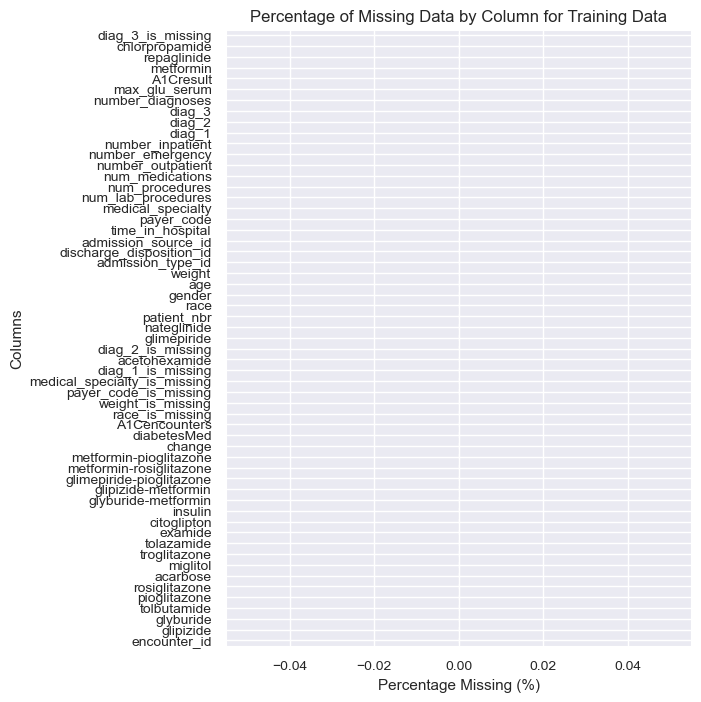

In [16]:
# look at imputed data
visualize_missingness(X_train_imp, figsize=(6, 8))

### Scaling

**Question:** Should we bother scaling? I think normalization would work better than standardization here for the various count variables (with the `num_` prefix) because they're probably quite right-skewed. They are mostly on similar scales already though.

In [17]:
# standardize data (just an example)
X_train_imp_std = scale_data(X_train_imp, ['time_in_hospital'])
X_train_imp_std.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,...,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,A1Cencounters,race_is_missing,weight_is_missing,payer_code_is_missing,medical_specialty_is_missing,diag_1_is_missing,diag_2_is_missing,diag_3_is_missing
98299,3.991e+08,1.313e+08,AfricanAmerican,Female,[90-100),[75-100),1.0,14.0,7.0,-0.803,MC,InternalMedicine,21.0,0.0,7.0,0.0,1.0,0.0,428,599,411,9.0,none,none,No,...,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,none,0,1,0,1,0,0,0
40063,1.246e+08,5.370e+07,Caucasian,Female,[50-60),[75-100),6.0,1.0,7.0,-0.134,MC,InternalMedicine,36.0,0.0,16.0,0.0,0.0,7.0,493,250.02,244,6.0,>300,none,No,...,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,none,0,1,1,1,0,0,0
25045,8.417e+07,2.134e+07,Caucasian,Male,[80-90),[75-100),3.0,3.0,1.0,0.201,MC,Orthopedics,33.0,1.0,36.0,0.0,0.0,0.0,996,427,413,8.0,none,none,No,...,No,No,Up,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,none,0,1,1,0,0,0,0
2178,1.416e+07,3.345e+06,AfricanAmerican,Female,[70-80),[75-100),2.0,1.0,1.0,0.201,MC,Urology,54.0,2.0,13.0,0.0,0.0,1.0,592,599,427,9.0,none,none,No,...,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,none,0,1,1,0,0,0,0
69063,1.957e+08,5.873e+07,Caucasian,Female,[50-60),[75-100),1.0,3.0,7.0,1.204,MC,InternalMedicine,62.0,1.0,24.0,0.0,0.0,1.0,562,438,401,8.0,none,none,No,...,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,none,0,1,0,1,0,0,0
